In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
import pymc as pm

In [2]:
from matplotlib import gridspec
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
import matplotlib as mpl

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams["axes.formatter.use_mathtext"] = True
leg_size = 14

def SetGrid(ratio=True):
    fig = plt.figure(figsize=(6, 6))
    if ratio:
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
        gs.update(wspace=0.025, hspace=0.1)
    else:
        gs = gridspec.GridSpec(1, 1)
    return fig,gs

In [3]:
def generate_truth(n_samples: int) -> np.ndarray:
    return np.random.normal(size=n_samples)

def confound(
    samples: np.ndarray,
    resolution: float,
) -> np.ndarray:
    noise = np.random.normal(loc=0., scale=resolution, size=samples.shape)
    return samples + noise

def generate_response(
    n_samples: int, 
    bins: list[float],
    resolution: float,
) -> np.ndarray:
    truth_data = np.random.normal(size=n_samples)
    truth_hist, _ = np.histogram(truth_data, bins=bins)
    observed_data = confound(truth_data, resolution=resolution)
    observed_hist, _ = np.histogram(observed_data, bins=bins)
    migrations, _, _ = np.histogram2d(observed_data, truth_data, bins=bins)
    response = migrations / truth_hist
    np.testing.assert_almost_equal(np.dot(response, truth_hist), observed_hist)
    return truth_hist, response

def generate_pseudoexperiment(
    n_samples: int,
    bins: list[float],
    resolution: float,
) -> dict[str, np.ndarray]:
    truth_data = generate_truth(n_samples)
    truth_hist, _ = np.histogram(truth_data, bins=bins)
    observed_data = confound(truth_data, resolution=resolution)
    observed_hist, _ = np.histogram(observed_data, bins=bins)
    return {"truth": truth_hist, "observed": observed_hist}

In [4]:
N = 100000
SMEAR = 0.5
BINS = [-np.inf, -4, -3, -2, -1, 0, 1, 2, 3, 4, np.inf]
N_PSEUDOEXPERIMENTS = 500

In [5]:
simulated_truth_hist, response = generate_response(n_samples=N*10, bins=BINS, resolution=SMEAR)
simulated_truth_hist = simulated_truth_hist / 10. # we use 10x luminosity to simulate the response 
pseudoexps = [
    generate_pseudoexperiment(n_samples=N, bins=BINS, resolution=SMEAR)
    for _ in range(N_PSEUDOEXPERIMENTS)
]

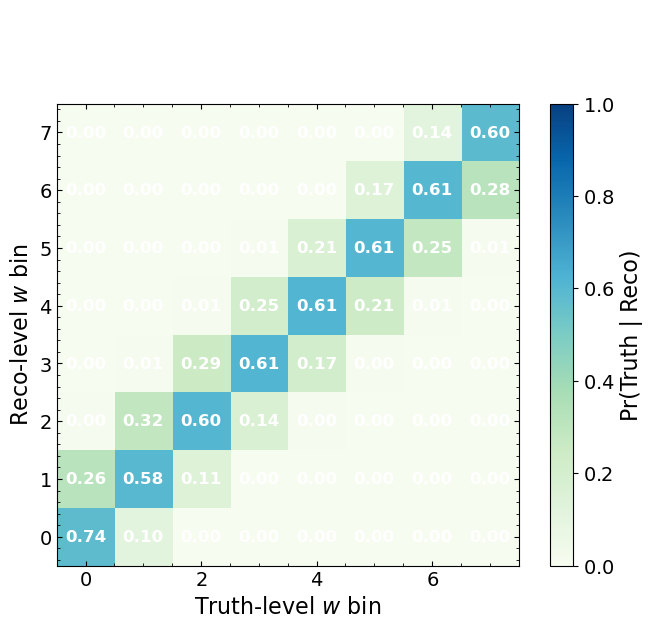

In [6]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks()
plt.yticks()

plt.imshow(response[1:-1, 1:-1], origin='lower',cmap="GnBu",vmin = 0,vmax = 1)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Pr(Truth | Reco)', )
cbar.ax.tick_params()
plt.xlabel("Truth-level $w$ bin", )
plt.ylabel("Reco-level $w$ bin", )

for i in range(len(response)):
    for j in range(len(response)):
        text = plt.text(j, i, f"{response[i, j]:.2f}", 
                        color="w", ha="center", va="center", fontweight="bold",fontsize=12)
        
plt.savefig('gaus_resp.pdf',bbox_inches='tight')

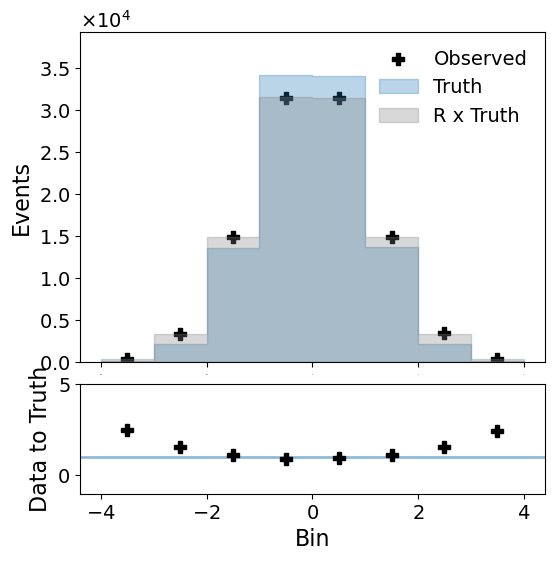

In [7]:
fig,gs = SetGrid(ratio=True) 
ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[1],sharex=ax0)

t = simulated_truth_hist
m = pseudoexps[0]["observed"]
R = response
bins = np.array(BINS) 
bincents = 0.5*(bins[1:]+bins[:-1])

ax0.scatter(bincents, m, s=80, color='black', marker="P", label='Observed')
ax0.fill_between(bins, np.insert(t, len(t), np.array(t[-1])), step='post', alpha=0.3, color='tab:blue', label='Truth')
ax0.fill_between(bins, np.insert(np.matmul(R, t), len(np.matmul(R, t)), np.array(np.matmul(R, t)[-1])), step='post', alpha=0.3, color='tab:grey', label='R x Truth')
ax0.set_ylabel("Events")
ax0.set_ylim(0, 1.15 * np.max(t))
ax0.tick_params(axis='y', which='major', labelsize=14)
ax0.legend(frameon=False, loc="upper right",fontsize=leg_size)
ax0.ticklabel_format(scilimits=(-3,3), useMathText = True)

r_obs = np.divide(m, t)
r_R = np.divide(R, t)
ax1.axhline(y=1.0, color='tab:blue', linestyle='-', linewidth=2, alpha=0.5)
ax1.errorbar(x=bincents, y=r_obs, label='Observed', color='k', marker='P', ms = 8, linestyle='none', elinewidth=3, capsize=2)
ax1.set_ylabel("Data to Truth")
ax1.set_xlabel("Bin")
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(-1, 5)

plt.savefig('gaus_init.pdf',bbox_inches='tight')
plt.show()

In [9]:
def compute_posterior(
    observed_hist: np.ndarray,
    response: np.ndarray,
    lower: np.ndarray,
    upper: np.ndarray,
) -> np.ndarray:
    model = pm.Model()

    with model:
        params = pm.DiscreteUniform(
            "params", 
            lower=lower, 
            upper=upper,
        )
        likelihood = pm.Poisson(
            "likelihood", mu=pm.math.dot(response, params),
            observed=observed_hist,
        )
        trace = pm.sample(draws=50000, tune=10000)
    return trace.posterior.params[0].to_numpy()

def plot_posterior(
    posterior: np.ndarray,
    truth_hist: np.ndarray,
    positions:list[float] = [-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5, 4.5 ],
    xerr: list[float] = np.zeros(10),
):
    vp = plt.violinplot(
        posterior,
        positions=positions,
        showextrema=False,
    )
    eb = plt.errorbar(
        x=positions,
        y=truth_hist,
        xerr=xerr,
        fmt=".",
        ls=":"
    )
    plt.legend([vp["bodies"][0], eb.lines], ["Posterior", "Truth"])
    plt.savefig('fbu_gaus.pdf',bbox_inches='tight')
    plt.show()

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [params]


Sampling 4 chains for 10_000 tune and 50_000 draw iterations (40_000 + 200_000 draws total) took 25 seconds.


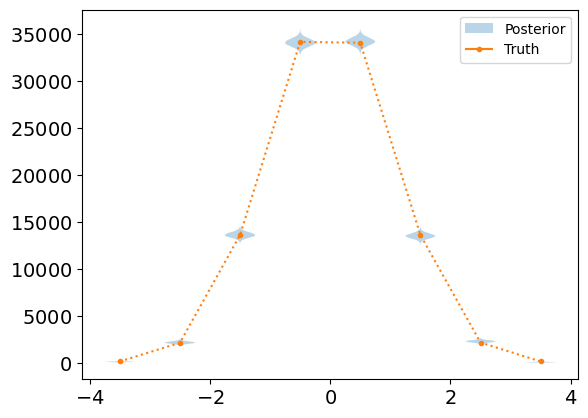

In [10]:
posterior = compute_posterior(
        observed_hist=pseudoexps[0]["observed"],
        response=response,
        lower=t // 5,
        upper=t * 5,
    )

# fbu = np.load("fpu_gaus_smear_{}_N_{}".format(SMEAR, N)+".npz")
# bincents = fbu["bins"]
# posterior = fbu["fbu"]
plot_posterior(posterior, simulated_truth_hist, positions=bincents)
np.savez_compressed("fpu_gaus_smear_{}_N_{}".format(SMEAR, N)+".npz", **{"bins": bincents, "m": pseudoexps[0]["observed"], "t": simulated_truth_hist, "fbu": posterior, "R": response})

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfb = tfp.bijectors

In [12]:
def IBU(data, init, r, det_binwidth=1, mc_binwidth=1, it=10):
    
    # initialize the truth distribution to the prior
    phis = [init]
    
    # iterate the procedure
    for i in range(it):
        
        # update the estimate for the matrix m
        m = r * phis[-1]
        m /= (m.sum(axis=1)[:,np.newaxis] + 10**-50)

        # update the estimate for the truth distribution
        # the factors of binwidth show up here to change probabilities into probability densities
        phis.append(np.dot(m.T, data)*det_binwidth/mc_binwidth)
        
    return phis

In [13]:
def MLE(model,ymes,ndim):
    x = tf.Variable(ndim*[1.0/ndim])
    loss = lambda: -model.log_prob(x, bijector_kwargs={'conditional_input': ymes})
    losses = tfp.math.minimize(loss,
                               num_steps=10000,
                               #convergence_criterion=(
                               #     tfp.optimizers.convergence_criteria.LossNotDecreasing(atol=0.001)),
                               trainable_variables=[x],
                               optimizer=tf.optimizers.Adam(learning_rate=0.001))
    return x

def MADE(data_shape, cond_shape):
    # Density estimation with MADE.
    made = tfb.AutoregressiveNetwork(params=2,
                                     hidden_units=[100,100,100], #To be changed when using bigger histograms
                                     event_shape=data_shape,
                                     activation='swish',
                                     conditional=True,
                                     conditional_event_shape=cond_shape,
                                    )
    distribution = tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[data_shape]),
        bijector=tfb.MaskedAutoregressiveFlow(made))

    # Construct and fit model.
    x_ = tfkl.Input(shape=(data_shape,), dtype=tf.float32)
    c_ = tfkl.Input(shape=(cond_shape,), dtype=tf.float32)
    log_prob_ = distribution.log_prob(x_, bijector_kwargs={'conditional_input': c_})
    model = tfk.Model([x_,c_], log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=4e-5),loss=lambda _, log_prob: -log_prob)
    return model, distribution

def NPU(ymes,tsim,Rin,N):
    # Inputs: 
    # ymes: Measured data provided in a histogram with M bins (M,)
    # Rin: Detector resolution matrix. First coordinate is the measured value and second coordinate is the truth level. (M,M)
    # N: Total number of observations
    # Returns samples from p(true|measured).  Would normally want the mode over true, which is equivalent to the MLE given p(true) is uniform.

    M = 1000000 # a big number - should make bigger later
    # ts = np.random.dirichlet(np.ones(len(ymes)),size=M)*N
    ts = np.random.uniform(0,1,(M,len(ymes))) #M values with B bins
    ts=ts/np.sum(ts,-1,keepdims=True)*N

    ms = []
    for j in range(len(ts)):
        if j % 100000 == 0: print(f"{j}/{len(ts)}")
        m_hold = [np.random.poisson(ts[j][i]) for i in range(len(ts[j]))] #stat fluctuations
        m_holds = np.random.multinomial(m_hold[0],Rin[:,0])
        for i in range(1, len(ts[j])):
            m_holds += np.random.multinomial(m_hold[i],Rin[:,i])
        ms += [m_holds]
        pass
    ts = np.array(ts)
    ms = np.array(ms)

    n = len(ts)
    x = ms # conditional feature
    y = ts # learn p(y|x)
    nx = N
    ny = N

    # Normalize the total number of events to make the NF easier to train
    x = x/float(nx)
    y = y/float(ny)

    model,dist = MADE(y.shape[1],x.shape[1])
    # Fit.
    batch_size = 10000
    myhistory = model.fit([y,x],
                          y=np.zeros((len(x),0), dtype=np.float32), #dummy labels
                          batch_size=batch_size,
                          epochs=1200,
                          verbose = 1)
    plt.plot(myhistory.history['loss'][10:-1])
    plt.xlabel("epochs")
    plt.ylabel("loss")

    nsample = 100000
    mle = MLE(dist,ymes/float(nx),y.shape[-1]).numpy()
    output = dist.sample(nsample, bijector_kwargs={'conditional_input': np.tile(ymes/float(nx),nsample).reshape([nsample,len(ymes)])}).numpy()
    return output*ny, mle*ny, dist

In [14]:
nbins = len(bins)-1
p = np.array([1./nbins for i in range(1, nbins+1)])
m = pseudoexps[0]["observed"]
R = response
it = 15
ibu = IBU(m, p, R, 1, 1, it)[it]

0/1000000
100000/1000000
200000/1000000
300000/1000000
400000/1000000
500000/1000000
600000/1000000
700000/1000000
800000/1000000
900000/1000000
Epoch 1/1200
100/100 [==============================] - 1s 3ms/step - loss: 9.3080
Epoch 2/1200
100/100 [==============================] - 0s 3ms/step - loss: 8.9723
Epoch 3/1200
100/100 [==============================] - 0s 3ms/step - loss: 8.5450
Epoch 4/1200
100/100 [==============================] - 0s 3ms/step - loss: 7.9250
Epoch 5/1200
100/100 [==============================] - 0s 3ms/step - loss: 6.9731
Epoch 6/1200
100/100 [==============================] - 0s 3ms/step - loss: 5.5448
Epoch 7/1200
100/100 [==============================] - 0s 3ms/step - loss: 3.5381
Epoch 8/1200
100/100 [==============================] - 0s 4ms/step - loss: 1.3442
Epoch 9/1200
100/100 [==============================] - 0s 3ms/step - loss: -0.3201
Epoch 10/1200
100/100 [==============================] - 0s 2ms/step - loss: -1.7466
Epoch 11/1200
100/100 

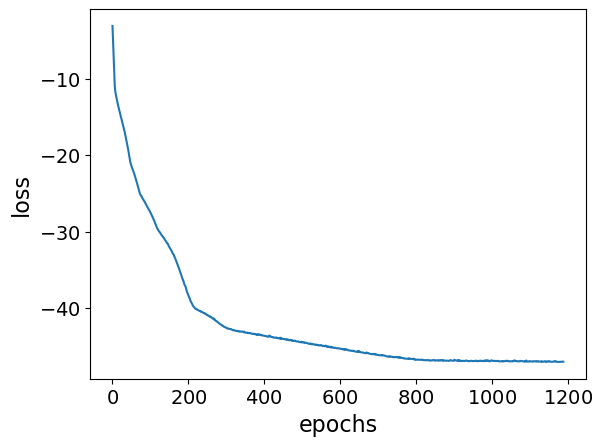

In [20]:
start_time_npu = time.perf_counter()

npu = NPU(pseudoexps[0]["observed"], simulated_truth_hist, response,np.sum(pseudoexps[0]["observed"]))
np.savez_compressed("npu_gaus_smear_{}_N_{}".format(SMEAR, N)+".npz", 
                    **{"bins": bincents, "m": pseudoexps[0]["observed"], "t": simulated_truth_hist, 
                       "npu": npu[0], "mle": npu[1], "ibu": ibu, "R": response})

end_time_npu = time.perf_counter()
execution_time_npu = end_time_npu - start_time_npu
print(f"Execution time: {execution_time_npu} seconds")

In [24]:
npu_saved=np.load("npu_gaus_smear_{}_N_100000".format(SMEAR)+".npz")
ibu = npu_saved['ibu']
npu = npu_saved['npu']
mle = npu_saved['mle']
t = npu_saved['t']
bins = npu_saved['bins']
print(npu.shape)

fbu=np.load("fpu_gaus_smear_{}_N_100000".format(SMEAR)+".npz")
posterior = fbu['fbu']
fbu_mean = np.mean(posterior,axis=0)
fbu_std = np.std(posterior,axis=0)
print(posterior.shape)

bins = np.array(BINS) 
bincents = 0.5*(bins[1:]+bins[:-1])
binsh = 0.03*(bins[1:]-bins[:-1])
print(bincents.shape)

(100000, 10)
(50000, 10)
(10,)


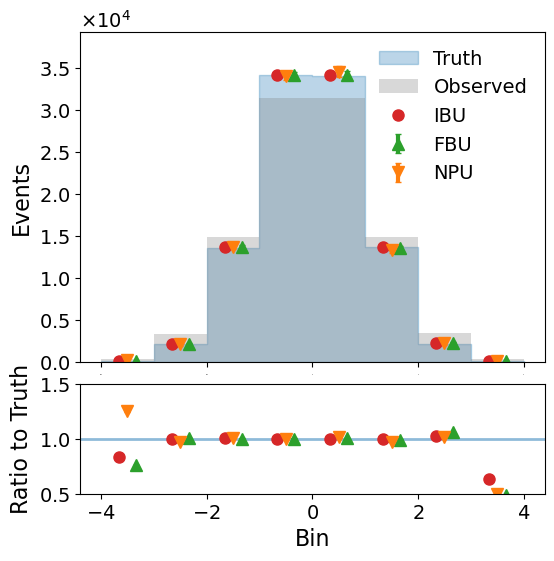

In [25]:
fig,gs = SetGrid(ratio=True) 
ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[1],sharex=ax0)

IBU = ibu
FBU = fbu_mean
FBU_err = fbu_std
# NPU = npu[0].mean(axis=0)
# NPU_err = npu[0].std(axis=0)
NPU = npu.mean(axis=0)
NPU_err = npu.std(axis=0)

ax0.fill_between(bins, np.insert(t, len(t), np.array(t[-1])), step='post', alpha=0.3, color='tab:blue', label='Truth')
ax0.fill_between(bins, np.insert(m, len(m), np.array(m[-1])), step='post', alpha=0.3, facecolor='tab:grey', label='Observed')
ax0.errorbar(x=bincents-0.16, y=IBU,   label='IBU', 
             color='tab:red', marker='o', ms = 8, linestyle='none', elinewidth=3, capsize=2)
ax0.errorbar(x=bincents+0.16, y=FBU, yerr=FBU_err, label='FBU', 
             color='tab:green', marker='^', ms = 8, linestyle='none', elinewidth=3, capsize=2)
ax0.errorbar(x=bincents,     y=NPU,   yerr=NPU_err, label='NPU', 
             color='tab:orange', marker='v', ms = 8, linestyle='none', elinewidth=3, capsize=2)
ax0.set_ylabel("Events")
# ax0.set_yscale('log')
ax0.legend(frameon=False, loc="upper right", fontsize=leg_size)
ax0.tick_params(axis='y', which='major', labelsize=14)
ax0.ticklabel_format(scilimits=(-3,3), useMathText = True)
ax0.set_ylim(0, 1.15 * np.max(t))

r_fbu = np.divide(np.mean(posterior,axis=0), t)
r_ibu = np.divide(ibu, t)
r_npu = np.divide(npu.mean(axis=0), t)
ax1.axhline(y=1.0, color='tab:blue', linestyle='-', linewidth=2, alpha=0.5)
ax1.errorbar(x=bincents-0.16, y=r_ibu, color='tab:red',   marker='o', 
             linewidth=3,linestyle="none",  label='IBU', ms = 8, elinewidth=3, capsize=2)
ax1.errorbar(x=bincents+0.16, y=r_fbu,  yerr=FBU_err/np.sum(t), color='tab:green', marker='^',
             linewidth=3,linestyle="none",  label='FBU', ms = 8, elinewidth=3, capsize=2)
ax1.errorbar(x=bincents,   y=r_npu, yerr=NPU_err/np.sum(t),  color='tab:orange', marker='v',
             linewidth=3,linestyle="none", label='NPU', ms = 8, elinewidth=3, capsize=2)
ax1.set_ylabel("Ratio to Truth")
ax1.set_xlabel("Bin")
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(0.5, 1.5)

fig.savefig("npu_gaussian_smearing_{}".format(SMEAR)+".pdf")
fig.show()

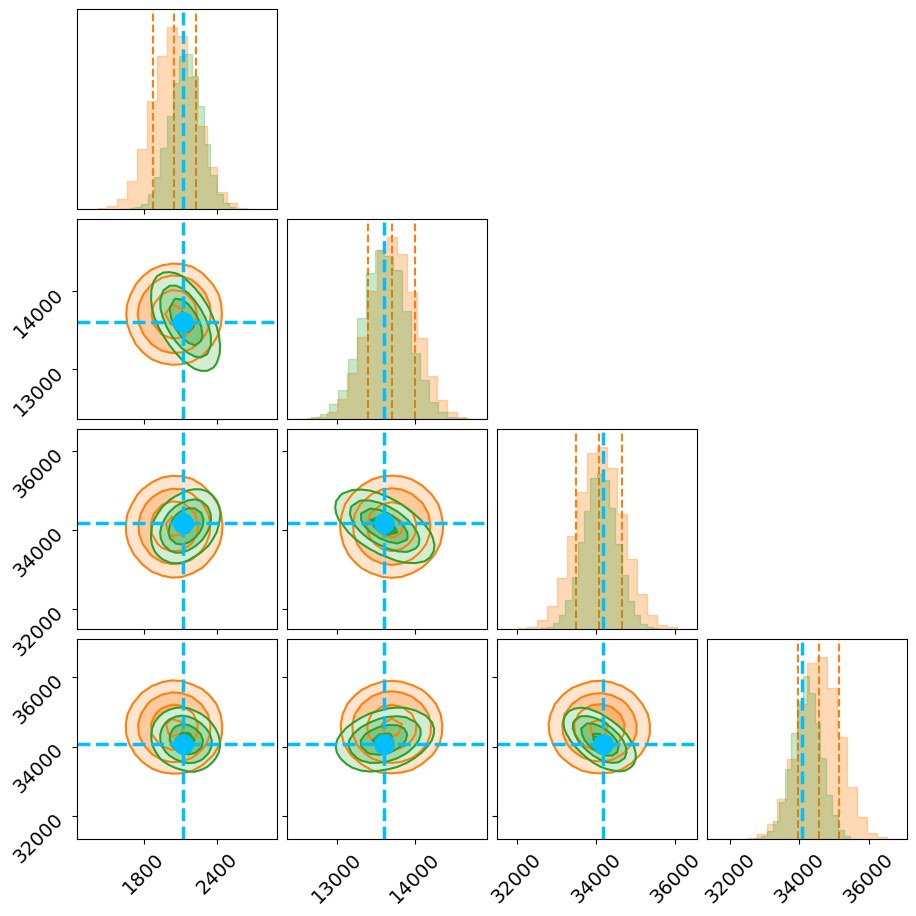

In [28]:
import corner 

posterior1 = npu[:, 2:6]
posterior2 = posterior[:, 2:6]

figure = corner.corner(
    posterior1,
    hist_kwargs={"color": 'tab:orange', "alpha": 0.3, "fill": True, },
    weights=np.ones(len(posterior1)) / len(posterior1),
    color="tab:orange",
    alpha=0.3,
    smooth=True,
    # plot_contours=False,
    fill_contours=True,
    plot_density=False,
    plot_datapoints=False,
    quantiles=[0.16, 0.5, 0.84],
    max_n_ticks=3,
    top_ticks=False,
)

corner.corner(
    posterior2,
    fig=figure,
    hist_kwargs={"color": 'tab:green', "alpha": 0.25, "fill": True, },
    weights=np.ones(len(posterior2)) / len(posterior2),
    smooth=True,
    # plot_contours=True,
    fill_contours=True,
    plot_density=False,
    plot_datapoints=False,
    color="tab:green",
    max_n_ticks=3,
)

corner.overplot_lines(figure, simulated_truth_hist[2:6], color="deepskyblue", linestyle='dashed', linewidth=2.5)
corner.overplot_points(figure, simulated_truth_hist[2:6][None], color="deepskyblue", marker='o', markersize=14)
figure.show()
figure.savefig('gaus_corner.pdf')

In [21]:
npus = []
nsample = 100000

start_time_npu = time.perf_counter()

for i in range(len(pseudoexps)):
    ymes = pseudoexps[i]["observed"]
    nx = np.sum(pseudoexps[i]["observed"])
    ny = np.sum(pseudoexps[i]["observed"])
    npus += [ny*npu[2].sample(nsample, bijector_kwargs={'conditional_input': np.tile(ymes/float(nx),nsample).reshape([nsample,len(ymes)])}).numpy()]

end_time_npu = time.perf_counter()
execution_time_npu = end_time_npu - start_time_npu
print(f"Execution time: {execution_time_npu} seconds")

Execution time: 39.13369357190095 seconds


In [82]:
fbus = []
for i in range(len(pseudoexps)):
    fbus += [compute_posterior(
            observed_hist=pseudoexps[i]["observed"],
            response=response,
            lower=t - 5*t**0.5,
            upper=t + 5*t**0.5,
        )]

In [ ]:
pulls_fbu = []
for i in range(len(fbus)):
    for j in range(len(simulated_truth_hist)):
        pulls_fbu+= [(np.mean(fbus[i],axis=0)[j]-simulated_truth_hist[j])/np.std(fbus[i],axis=0)[j]]

In [22]:
pulls_npu = []
for i in range(len(npus)):
    for j in range(len(simulated_truth_hist)):
        pulls_npu+= [(np.mean(npus[i],axis=0)[j]-simulated_truth_hist[j])/np.std(npus[i],axis=0)[j]]

In [107]:
np.savez_compressed("pulls_smear_{}_N_{}".format(SMEAR, N)+".npz", **{"npu": pulls_npu, "fbu": pulls_fbu})

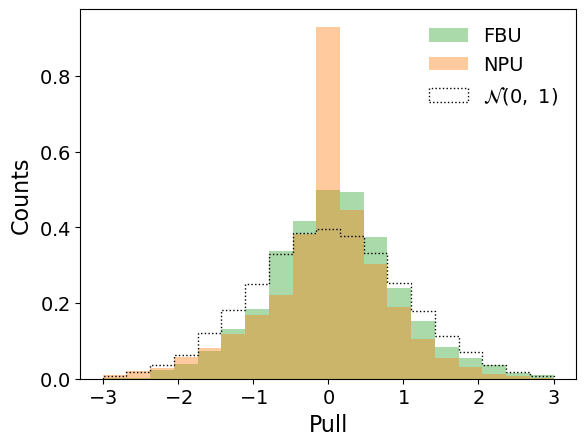

In [23]:
pulls=np.load("pulls_smear_0.5_N_50000.npz")
pulls_fbu = pulls['fbu']
# pulls_npu = pulls['npu']

# plt.hist(pulls_fbu,bins=np.linspace(-3,3,20),alpha=0.4, color='tab:green', density=True,label="fbu ($\mu=$"+'{:.2f}'.format(np.mean(pulls_fbu))+', $\sigma=$'+'{:.2f}'.format(np.std(pulls_fbu))+")")
# plt.hist(pulls_npu,bins=np.linspace(-3,3,20),alpha=0.4, color='tab:orange', density=True,label="npu ($\mu=$"+'{:.2f}'.format(np.mean(pulls_npu))+', $\sigma=$'+'{:.2f}'.format(np.std(pulls_npu))+")")
plt.hist(pulls_fbu,bins=np.linspace(-3,3,20),alpha=0.4, color='tab:green',label="FBU", density=True)
plt.hist(pulls_npu,bins=np.linspace(-3,3,20),alpha=0.4, color='tab:orange',label="NPU", density=True)
plt.hist(np.random.normal(0,1,100000),weights=np.ones(100000)*0.01,bins=np.linspace(-3,3,20),density=True, histtype="step",ls=":",color="black",label='$\mathcal{N}(0,~1)$')
plt.ylabel("Counts")
plt.xlabel("Pull")
plt.legend(frameon=False, loc="upper right", fontsize=14)
plt.savefig("pulls_smear_{}_N_{}".format(SMEAR, N)+".pdf")

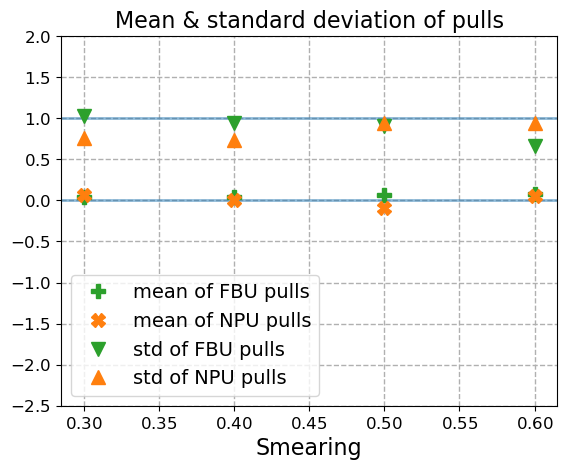

<Figure size 640x480 with 0 Axes>

In [109]:
smearing = [0.3, 0.4, 0.5, 0.6]
fbu_mean = [0.04, 0.04, 0.06, 0.08]
npu_mean = [0.07, 0.0, -0.09, 0.05]
fbu_std = [1.03, 0.94, 0.91, 0.66]
npu_std = [0.76,0.74, 0.94, 0.94]

plt.errorbar(x=smearing, y=fbu_mean, ls="none", marker='P', label='mean of FBU pulls', color='tab:green', ms=10)
plt.errorbar(x=smearing, y=npu_mean, ls="none",marker='X', label='mean of NPU pulls', color='tab:orange', ms=10)

plt.errorbar(x=smearing, y=fbu_std, ls="none", marker='v', label='std of FBU pulls', color='tab:green', ms=10)
plt.errorbar(x=smearing, y=npu_std, ls="none",marker='^', label='std of NPU pulls', color='tab:orange', ms=10)

plt.axhline(y=0, color='tab:blue', linestyle='-', linewidth=2, alpha=0.5)
plt.axhline(y=1, color='tab:blue', linestyle='-', linewidth=2, alpha=0.5)
plt.grid(True, linestyle='dashed', linewidth=1)
plt.ylim(-2.5, 2)
plt.xlabel("Smearing", fontsize=16)
plt.title("Mean & standard deviation of pulls", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="lower left", fontsize=14)
plt.savefig("pulls_mean_std.pdf")
plt.show()
plt.clf()

In [ ]:
# plt.plot(np.std(posterior,axis=0),np.std(npu,axis=0),ls="none",marker='>')
# plt.xlim([0,400])
# plt.ylim([0,400])
# plt.xlabel("fbu uncert")
# plt.ylabel("npu uncert")
# plt.plot([0,400],[0,400],ls=":",color='gray')

In [ ]:
#N.B. priors are not quite the same!